In [1]:
# Install the required libraries
!pip install opendatasets --upgrade --quiet


In [2]:
import opendatasets as od

# Download the dataset from Kaggle
dataset_url = 'https://www.kaggle.com/datasets/nilesh789/eurosat-rgb'
od.download(dataset_url)

# Set the path to the image folder
data_path = '/content/eurosat-rgb/2750'


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: akshayanand2002
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nilesh789/eurosat-rgb


100%|██████████| 89.6M/89.6M [00:01<00:00, 47.2MB/s]


In [3]:
import os
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.layers import Input, Dense, Activation, Dropout, GlobalAveragePooling2D, BatchNormalization, ZeroPadding2D, AveragePooling2D, MaxPooling2D, Convolution2D
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, AveragePooling2D
#from keras.models import Model
#from keras.optimizers import SGD
#import keras.backend as K


In [4]:
# def densenet121_model(img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4, num_classes=None):
#     # DenseNet 121 Model for Keras

#     # Handle Dimension Ordering for different backends
#     global concat_axis
#     img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
#     concat_axis = 3

#     # From architecture for ImageNet (Table 1 in the paper)
#     nb_filter = 64
#     nb_layers = [6, 12, 24, 16]  # For DenseNet-121

#     # Initial convolution
#     x = Conv2D(nb_filter, (7, 7), strides=(2, 2), name='conv1', use_bias=False)(img_input)
#     x = BatchNormalization(axis=concat_axis)(x)
#     x = Activation('relu')(x)
#     x = MaxPooling2D((3, 3), strides=(2, 2))(x)

#     # Add dense blocks
#     for block_idx in range(nb_dense_block - 1):
#         stage = block_idx + 2
#         x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate)
#         x = transition_block(x, stage, nb_filter, dropout_rate=dropout_rate)
#         nb_filter = int(nb_filter)

#     final_stage = stage + 1
#     x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate)

#     x = BatchNormalization(axis=concat_axis)(x)
#     x = Activation('relu')(x)

#     x_fc = GlobalAveragePooling2D()(x)
#     x_fc = Dense(1000)(x_fc)
#     x_fc = Activation('softmax')(x_fc)

#     model = Model(img_input, x_fc)

#     # Replace the final layer for fine-tuning
#     x_newfc = GlobalAveragePooling2D()(x)
#     x_newfc = Dense(num_classes)(x_newfc)
#     x_newfc = Activation('softmax')(x_newfc)

#     model = Model(img_input, x_newfc)

#     # Compile the model
#     sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
#     model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

#     return model

# def conv_block(x, stage, branch, nb_filter, dropout_rate=None):
#     # Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and optional dropout
#     inter_channel = nb_filter * 4
#     x = BatchNormalization(axis=concat_axis)(x)
#     x = Activation('relu')(x)
#     x = Conv2D(inter_channel, (1, 1), use_bias=False)(x)

#     if dropout_rate:
#         x = Dropout(dropout_rate)(x)

#     x = BatchNormalization(axis=concat_axis)(x)
#     x = Activation('relu')(x)
#     x = ZeroPadding2D((1, 1))(x)
#     x = Conv2D(nb_filter, (3, 3), use_bias=False)(x)

#     if dropout_rate:
#         x = Dropout(dropout_rate)(x)

#     return x

# def transition_block(x, stage, nb_filter, dropout_rate=None):
#     # Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout
#     x = BatchNormalization(axis=concat_axis)(x)
#     x = Activation('relu')(x)
#     x = Conv2D(int(nb_filter), (1, 1), use_bias=False)(x)

#     if dropout_rate:
#         x = Dropout(dropout_rate)(x)

#     x = AveragePooling2D((2, 2), strides=(2, 2))(x)
#     return x

# def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, grow_nb_filters=True):
#     # Build a dense_block where the output of each conv_block is fed to subsequent ones
#     concat_feat = x

#     for i in range(nb_layers):
#         branch = i + 1
#         x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate)
#         concat_feat = K.concatenate([concat_feat, x], axis=concat_axis)

#         if grow_nb_filters:
#             nb_filter += growth_rate

#     return concat_feat, nb_filter

from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, AveragePooling2D, Concatenate
from keras.models import Model
from keras.optimizers import SGD
import keras.backend as K

def densenet121_model(img_rows, img_cols, color_type=1, nb_dense_block=4, growth_rate=32, nb_filter=64, reduction=0.5, dropout_rate=0.0, weight_decay=1e-4, num_classes=None):
    # DenseNet 121 Model for Keras

    # Handle Dimension Ordering for different backends
    global concat_axis
    img_input = Input(shape=(img_rows, img_cols, color_type), name='data')
    concat_axis = 3

    # From architecture for ImageNet (Table 1 in the paper)
    nb_filter = 64
    nb_layers = [6, 12, 24, 16]  # For DenseNet-121

    # Initial convolution
    x = Conv2D(nb_filter, (7, 7), strides=(2, 2), name='conv1', use_bias=False)(img_input)
    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Add dense blocks
    for block_idx in range(nb_dense_block - 1):
        stage = block_idx + 2
        x, nb_filter = dense_block(x, stage, nb_layers[block_idx], nb_filter, growth_rate, dropout_rate=dropout_rate)
        x = transition_block(x, stage, nb_filter, dropout_rate=dropout_rate)
        nb_filter = int(nb_filter)

    final_stage = stage + 1
    x, nb_filter = dense_block(x, final_stage, nb_layers[-1], nb_filter, growth_rate, dropout_rate=dropout_rate)

    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)

    x_fc = GlobalAveragePooling2D()(x)
    x_fc = Dense(1000)(x_fc)
    x_fc = Activation('softmax')(x_fc)

    model = Model(img_input, x_fc)

    # Replace the final layer for fine-tuning
    x_newfc = GlobalAveragePooling2D()(x)
    x_newfc = Dense(num_classes)(x_newfc)
    x_newfc = Activation('softmax')(x_newfc)

    model = Model(img_input, x_newfc)

    # Compile the model
    sgd = SGD(learning_rate=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

def conv_block(x, stage, branch, nb_filter, dropout_rate=None):
    # Apply BatchNorm, Relu, bottleneck 1x1 Conv2D, 3x3 Conv2D, and optional dropout
    inter_channel = nb_filter * 4
    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(inter_channel, (1, 1), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(nb_filter, (3, 3), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    return x

def transition_block(x, stage, nb_filter, dropout_rate=None):
    # Apply BatchNorm, 1x1 Convolution, averagePooling, optional compression, dropout
    x = BatchNormalization(axis=concat_axis)(x)
    x = Activation('relu')(x)
    x = Conv2D(int(nb_filter), (1, 1), use_bias=False)(x)

    if dropout_rate:
        x = Dropout(dropout_rate)(x)

    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

def dense_block(x, stage, nb_layers, nb_filter, growth_rate, dropout_rate=None, grow_nb_filters=True):
    # Build a dense_block where the output of each conv_block is fed to subsequent ones
    concat_feat = x

    for i in range(nb_layers):
        branch = i + 1
        x = conv_block(concat_feat, stage, branch, growth_rate, dropout_rate)
        concat_feat = Concatenate(axis=concat_axis)([concat_feat, x])

        if grow_nb_filters:
            nb_filter += growth_rate

    return concat_feat, nb_filter


In [5]:
def load_data():
    data = []
    labels = []
    image_paths = sorted(list(os.listdir(data_path)))

    random.seed(42)
    random.shuffle(image_paths)

    for label_name in image_paths:
        label_folder = os.path.join(data_path, label_name)
        images = os.listdir(label_folder)

        for img_name in images:
            img_path = os.path.join(label_folder, img_name)
            image = cv2.imread(img_path)
            image = cv2.resize(image, (64, 64))  # Resize images
            image = img_to_array(image)
            data.append(image)
            labels.append(label_name)

    data = np.array(data, dtype="float32") / 255.0  # Normalize the images
    labels = np.array(labels)

    # One-hot encode the labels
    mlb = LabelBinarizer()
    labels = mlb.fit_transform(labels)

    # Split the data into training and testing sets
    (x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.25, random_state=42)

    return x_train, y_train, x_test, y_test

# Load data
x_train, y_train, x_test, y_test = load_data()


In [6]:
# Initialize the model
img_rows, img_cols = 64, 64  # Image dimensions
color_type = 3  # RGB
num_classes = 10  # Number of classes in the UC Merced dataset

model = densenet121_model(img_rows=img_rows, img_cols=img_cols, color_type=color_type, num_classes=num_classes)

# Make sure the DenseNet model uses 'strides' instead of 'subsample' if you're manually defining it
# Example:
# Conv2D(filters, kernel_size, strides=(2, 2), use_bias=False)

# Define the model checkpoint callback to save the best model
filepath = "eurosat.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=5,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint],
                    shuffle=True)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/5
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.4841 - loss: 1.4935
Epoch 1: val_accuracy improved from -inf to 0.41867, saving model to eurosat.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1237s 936ms/step - accuracy: 0.4841 - loss: 1.4933 - val_accuracy: 0.4187 - val_loss: 2.3064
Epoch 2/5
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.6541 - loss: 0.9900
Epoch 2: val_accuracy improved from 0.41867 to 0.42993, saving model to eurosat.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1205s 922ms/step - accuracy: 0.6541 - loss: 0.9900 - val_accuracy: 0.4299 - val_loss: 2.5381
Epoch 3/5
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.7256 - loss: 0.7876
Epoch 3: val_accuracy improved from 0.42993 to 0.46622, saving model to eurosat.keras
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 1185s 935ms/step - accuracy: 0.7256 - loss: 0.7876 - val_accuracy: 0.4662 - val_loss: 1.9065
Epoch 4/5
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.7662 - loss: 0.6672
Epoch 4: val_accu

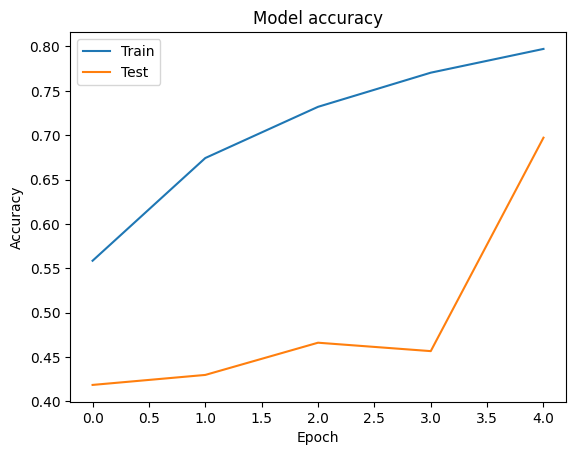

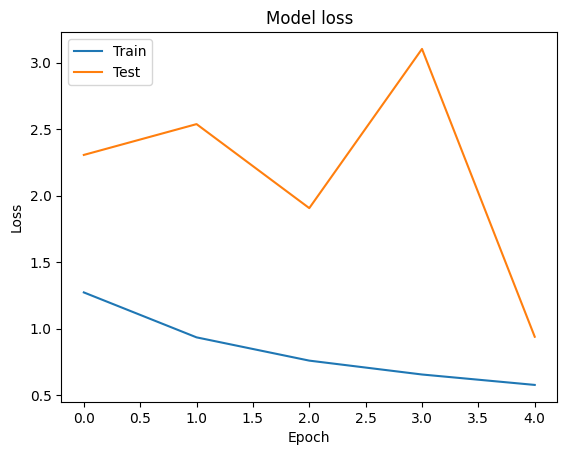

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [8]:
from keras.models import load_model

# Load the best saved model
best_model = load_model('bestmodel.hdf5')

# Make predictions on the test data
y_pred = best_model.predict(x_test)

# Evaluate the model
total = 0
accurate = 0
for i in range(len(y_pred)):
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
        accurate += 1
    total += 1

accuracy = accurate / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'bestmodel.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)